# Squared Exponential kernel Gaussian process - PriorCVAE


This is a demo notebook to showcase the usage of PriorCVAE model on a Gaussian process dataset which is generated using a SquaredExponential kernel.

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL

import jax.config as config
config.update("jax_enable_x64", True)

### Configuration

In [2]:
args = {
        "conditional": True,
        
        # architecture
        "input_dim" : 80,
        "hidden_dim": 60,
        "latent_dim": 40,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 4000,
        "learning_rate": 1e-3,
        "vae_var": 1.,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_mcmc_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data

We generate the data using an SquaredExponential kernel with lengthscale that is uniformly sampled. We plot a sample from the GP and plot the trajectories and lengthscales.

In [3]:
kernel = SquaredExponential()

gp_set = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True)  

In [4]:
sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1000)

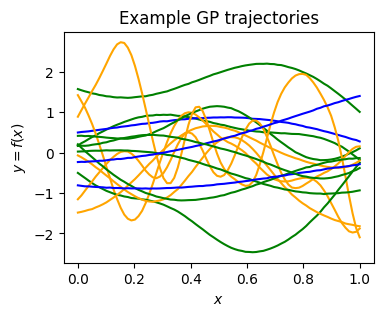

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')

plt.show()

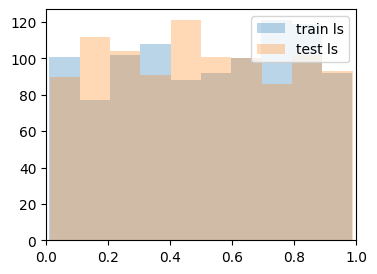

In [6]:
# Plot sample lengthscales
plt.figure(figsize=(4,3))
plt.hist(sample_ls_train[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_test[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()
plt.show()

### PriorCVAE Model

We define the PriorCVAE model, optimizer, and initialize the parameters of the model randomly.

In [7]:
conditional = args["conditional"]
out_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
latent_dim = args["latent_dim"]
batch_size = args["batch_size"]
num_iterations  = args["num_iterations"]
true_ls = args["true_ls"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)
loss = SquaredSumAndKL(conditional=conditional, vae_var=vae_var)

### Train the model

Train the model and plot the train loss and the test loss.

In [9]:
trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_set, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')

[    1] training loss: 8506.321, test loss: 82074.363
[   11] training loss: 5641.426, test loss: 55178.618
[   21] training loss: 4333.634, test loss: 48096.049
[   31] training loss: 4357.384, test loss: 42844.465
[   41] training loss: 3447.336, test loss: 36331.899
[   51] training loss: 3059.230, test loss: 30789.618
[   61] training loss: 2779.516, test loss: 27665.474
[   71] training loss: 2698.414, test loss: 25538.481
[   81] training loss: 2633.937, test loss: 24542.738
[   91] training loss: 2524.597, test loss: 22893.555
[  101] training loss: 2066.225, test loss: 22425.408
[  111] training loss: 2152.771, test loss: 21431.233
[  121] training loss: 2062.256, test loss: 20270.275
[  131] training loss: 1724.570, test loss: 20080.818
[  141] training loss: 1842.849, test loss: 19354.006
[  151] training loss: 2043.571, test loss: 19187.947
[  161] training loss: 1717.665, test loss: 18621.918
[  171] training loss: 1772.713, test loss: 18283.782
[  181] training loss: 1817.

[ 1541] training loss: 1070.716, test loss: 9351.105
[ 1551] training loss: 965.385, test loss: 9379.307
[ 1561] training loss: 1012.589, test loss: 9275.031
[ 1571] training loss: 899.230, test loss: 9376.092
[ 1581] training loss: 877.786, test loss: 9313.878
[ 1591] training loss: 899.157, test loss: 9351.222
[ 1601] training loss: 858.163, test loss: 9438.616
[ 1611] training loss: 810.204, test loss: 9294.898
[ 1621] training loss: 977.643, test loss: 9360.481
[ 1631] training loss: 998.771, test loss: 9321.989
[ 1641] training loss: 1048.913, test loss: 9250.861
[ 1651] training loss: 798.036, test loss: 9169.877
[ 1661] training loss: 820.044, test loss: 9284.156
[ 1671] training loss: 913.592, test loss: 9107.284
[ 1681] training loss: 874.654, test loss: 9220.369
[ 1691] training loss: 817.152, test loss: 9289.890
[ 1701] training loss: 1012.602, test loss: 9269.354
[ 1711] training loss: 746.352, test loss: 9237.192
[ 1721] training loss: 937.497, test loss: 9229.014
[ 1731] 

[ 3121] training loss: 858.418, test loss: 8540.787
[ 3131] training loss: 797.445, test loss: 8557.550
[ 3141] training loss: 950.368, test loss: 8585.563
[ 3151] training loss: 773.788, test loss: 8515.010
[ 3161] training loss: 817.774, test loss: 8591.541
[ 3171] training loss: 887.712, test loss: 8640.865
[ 3181] training loss: 973.005, test loss: 8462.001
[ 3191] training loss: 806.892, test loss: 8600.424
[ 3201] training loss: 811.031, test loss: 8561.294
[ 3211] training loss: 875.257, test loss: 8473.598
[ 3221] training loss: 914.997, test loss: 8596.166
[ 3231] training loss: 879.701, test loss: 8590.038
[ 3241] training loss: 786.767, test loss: 8453.012
[ 3251] training loss: 881.551, test loss: 8567.620
[ 3261] training loss: 750.152, test loss: 8536.471
[ 3271] training loss: 842.607, test loss: 8527.442
[ 3281] training loss: 840.529, test loss: 8591.843
[ 3291] training loss: 775.221, test loss: 8564.995
[ 3301] training loss: 850.922, test loss: 8586.971
[ 3311] trai

Text(0.5, 1.0, 'Test loss')

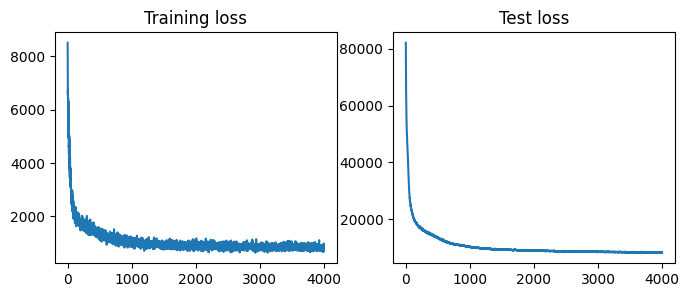

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


### Trained Decoder

We plot a sample of trajectories from the trained decoder model.

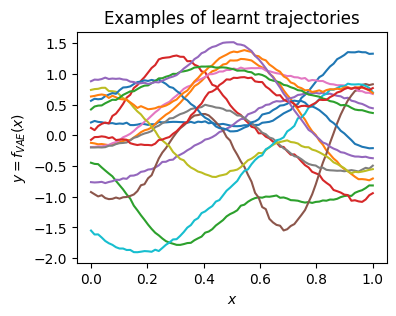

In [11]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)

c = true_ls * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

### Inference with MCMC

We randomly generate observations from the GP.

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

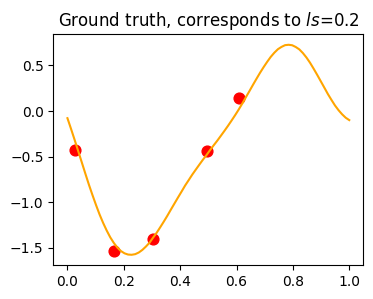

In [12]:
x = sample_x_train[0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=true_ls, variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

# add data to args. This is used by MCMC.
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

### Numpyro model

We define a Nupmyro model to run MCMC.

In [13]:
c = true_ls * jnp.ones((1, )) if conditional else None

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params, c=c)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.62      0.16     -0.61     -0.90     -0.37  17223.51      1.00
      f[1]     -0.64      0.17     -0.63     -0.93     -0.37  17201.76      1.00
      f[2]     -0.65      0.17     -0.64     -0.93     -0.37  17108.20      1.00
      f[3]     -0.70      0.17     -0.70     -0.99     -0.43  17456.56      1.00
      f[4]     -0.75      0.17     -0.74     -1.03     -0.47  17366.38      1.00
      f[5]     -0.80      0.17     -0.80     -1.09     -0.54  17317.48      1.00
      f[6]     -0.84      0.16     -0.84     -1.10     -0.57  17355.68      1.00
      f[7]     -0.89      0.16     -0.89     -1.15     -0.64  17186.57      1.00
      f[8]     -0.94      0.15     -0.94     -1.19     -0.70  17141.13      1.00
      f[9]     -1.00      0.14     -1.00     -1.23     -0.77  16908.96      1.00
     f[10]     -1.06      0.14     -1.06     -1.28     -0.84  16761.58      1.00
     f[11]     -1.11      0

Average ESS for all VAE-GP effects : 14051


## Plotting

We plot the trajectory after MCMC.

Text(0.5, 1.0, 'PriorCVAE inference')

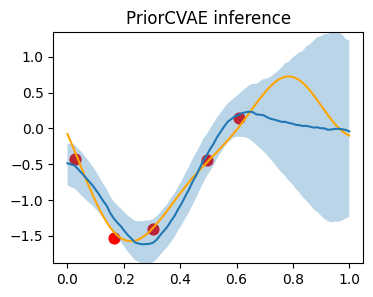

In [14]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)

c = .1 * jnp.ones((1, )) if conditional else None
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params, c)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorCVAE inference')